# 1 Toy example

First we will examine the adversarial training on a toy example, taken from Ref. [1]. It is a simple classification problem with two features (contained in X), which depend on the protected parameter Z:


$x \sim \mathcal{N} \left(( 0,0 ) , \left[
\begin{matrix}
-0.5 &  1\\
1 &  -0.5
\end{matrix} \right] \right) $ when Y = 0,

$x \sim \mathcal{N} \left(( 1,1+z ) , \left[
\begin{matrix}
1 &  0\\
0 &  1
\end{matrix} \right] \right) $ when Y = 1,



[1] https://arxiv.org/abs/1611.01046


## 1.1 Visualise the data

Let's generate the data and visualise it below. Darker reds correspond to higher values of z.

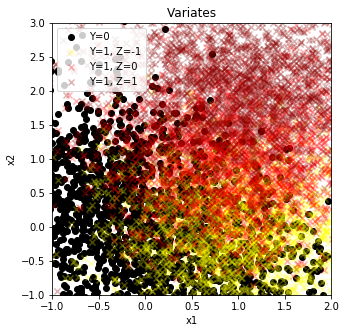

In [55]:
import matplotlib.pyplot as plt
import numpy as np

def generate_toys(n_samples, z=None, train=True):
    """
    Args:
        n_samples (int): number of examples to generate
        z (None or float): generate events at a particular value of z, by default depends on the label
        
    Returns a tuple (X, Y, Z) of arrays. In each array, a row is an instance.
    """
    
    sigma = 1.0

    # labels Y: first half are zeros, second half are ones
    Y = np.zeros(n_samples)
    Y[n_samples//2:] = 1

    # protected parameter Z
    # in the training set (z=None) z depends on the label
    # (i.e. mass distribution depends on signal/background)
    if z == None:
        Z0 = np.zeros(n_samples//2)
        Z1 = np.random.normal(0, 1, size=n_samples//2)
    # or generate at specific value of Z (for evaluation purposes)
    else:
        Z0 = z * np.ones(n_samples//2)
        Z1 = z * np.ones(n_samples//2)
    Z = np.concatenate([Z0, Z1])

    # feature X depend on the value of Z (i.e. kinematics depends on the mass)
    X0 = np.random.multivariate_normal([0, 0], [[sigma, -.5*sigma], [-.5*sigma, sigma]], size=n_samples//2)
    X1 = np.random.multivariate_normal([1, 1], 0.5*np.eye(2), size=n_samples//2)
    X1[:,1] += Z1
    X = np.concatenate([X0, X1])

    return X, Y, Z

  
def show_variates(ax, generate):
    """
    Plots the random variates.
    
    Args:
        ax (matplotlib axis): Axis on which to plot the variates.
        generate (function): function to generate the variates.
    """
    
    # generate
    n_samples = 5000
    X0, Y0, Z0 = generate(n_samples, z=0)
    Y0 = Y0.ravel()
    Z0 = Z0.ravel()
    X1, Y1, Z1 = generate(n_samples, z=1)
    Y1 = Y1.ravel()
    Z1 = Z1.ravel()
    X_1, Y_1, Z_1 = generate(n_samples, z=-1)
    Y_1 = Y_1.ravel()
    Z_1 = Z_1.ravel()
    
    # plot
    ax.scatter(X0[Y0==0,0], X0[Y0==0,1], marker='o', color='k', alpha=1.0, label='Y=0')
    ax.scatter(X_1[Y_1==1,0], X_1[Y_1==1,1], marker='x', c='yellow', alpha=0.3, label='Y=1, Z=-1')
    ax.scatter(X0[Y0==1,0], X0[Y0==1,1], marker='x', c='red', alpha=0.3, label='Y=1, Z=0')
    ax.scatter(X1[Y1==1,0], X1[Y1==1,1], marker='x', c='darkred', alpha=0.3, label='Y=1, Z=1')
    
    
    # cosmetics
    ax.set_ylim(-1, 3)
    ax.set_xlim(-1, 2)
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    leg = ax.legend(loc='best')
    ax.set_title('Variates')

fig, ax = plt.subplots(figsize=(5,5))
show_variates(ax, generate_toys)

## 1.2 Classifier definition

Let's define a basic Classifier class. It will be used in both the normal and the adversarial training.

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Classifier(nn.Module):
    """
    Basic classifier class
    
    Args:
        width (int): number of nodes in each layer
    """
    
    def __init__(self, width, n_inputs=2):
        super(Classifier, self).__init__()
        self.width = width
    
        # input layer
        self.input = nn.Linear(n_inputs, width)
    
        # hidden layers
        self.h1 = nn.Linear(width, width)
        self.h2 = nn.Linear(width, width)
    
        # output layer
        self.output = nn.Linear(width, 1)

    def forward(self, x):
    
        # input layer
        x = F.relu(self.input(x))
    
        # hidden layers
        x = F.relu(self.h1(x))
        x = F.relu(self.h2(x))
        
        # output layer
        x = torch.sigmoid(self.output(x))
    
        return x


## 1.3 Standard (non-adversarial) classifier training and evaluation

Let's first train a vanilla classifier and see how it performs.

### Training block

Training block is written as a function in order to emphasize similarities between the toy and the physics example. All that will be different is the function which generates X, Y, and Z.

Done with training


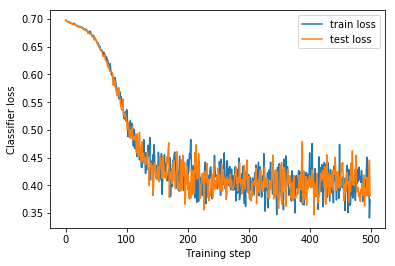

In [57]:
def normal_training(generating_function, N_train=500):
    
    # determine the size of hte classifier
    X, _, _ = generating_function(10)
    n_inputs = X.shape[1]
    
    # create the network and the optimiser
    clf = Classifier(10, n_inputs=n_inputs)
    optimiser = torch.optim.Adam(clf.parameters(), lr=0.001)
    criterion = nn.BCELoss()

    # track the losses
    clf_losses = []
    clf_losses_test = []

    for _ in range(N_train):

        # create the data
        X, Y, Z = generating_function(512)
        X = torch.as_tensor(X, dtype=torch.float)
        Y = torch.as_tensor(Y.reshape(-1, 1), dtype=torch.float)
        Z = torch.as_tensor(Z.reshape(-1, 1), dtype=torch.float)

        # make the training loss
        output = clf(X)
        loss = criterion(output, Y)
        clf_losses.append(loss.data.numpy().item())

        # backprop
        clf.zero_grad()
        loss.backward()
        optimiser.step()
        
        # test loss
        X_test, Y_test, _ = generating_function(512, train=False)
        X_test = torch.as_tensor(X_test, dtype=torch.float)
        Y_test = torch.as_tensor(Y_test.reshape(-1, 1), dtype=torch.float)
        output_test = clf(X_test)
        loss_test = criterion(output_test, Y_test)
        clf_losses_test.append(loss_test.data.numpy().item())
    
    print('Done with training')

    fig, ax = plt.subplots()
    ax.plot(range(len(clf_losses)), clf_losses, label='train loss')
    ax.plot(range(len(clf_losses_test)), clf_losses_test, label='test loss')
    ax.set_xlabel('Training step')
    ax.set_ylabel('Classifier loss')
    ax.legend(loc='best')
    plt.show()
    
    return clf

clf_toys = normal_training(generate_toys)

### Evaluation


Lots of plotting code, no need to read, just look at the figures on the bottom.

-----

The first panel shows the variates as above, with darker reds meaning higher Z values.

The second panel shows the classifier output as a surface over the 2D input plane.

The third panel shows the ROC curves for examples generated at Z=-1, 0, and 1. It is clear that separation is easier for higher values of Z.

The fourth panel shows the classifier output distribution for examples at Z=-1, 0, and 1. Similarly, the distribution of Z=1 examples is shifted to the right.

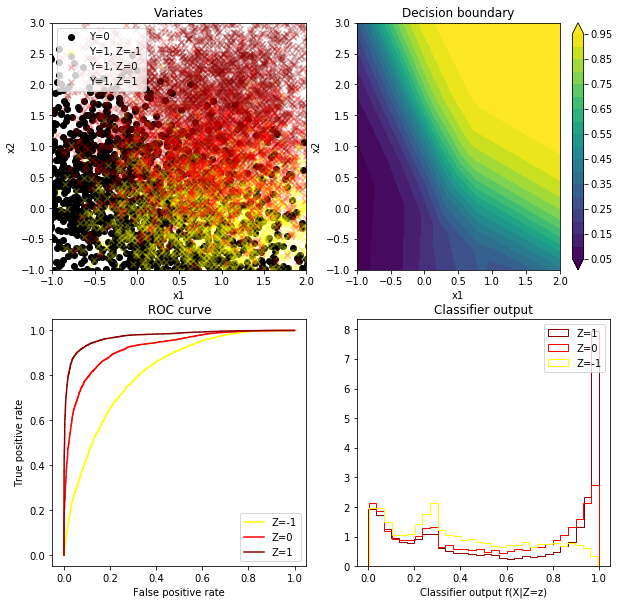

In [58]:
from sklearn.metrics import roc_curve

def show_roc_curves(ax, clf, generate):

    # generate test data
    n_samples = 10000
    X0, Y0, Z0 = generate(n_samples, z=0)
    X1, Y1, Z1 = generate(n_samples, z=1)
    X_1, Y_1, Z_1 = generate(n_samples, z=-1)

    # compute the roc curves
    Y0_pred = clf(torch.as_tensor(X0, dtype=torch.float))
    fpr0, tpr0, _ = roc_curve(Y0, Y0_pred.data)

    Y1_pred = clf(torch.as_tensor(X1, dtype=torch.float))
    fpr1, tpr1, _ = roc_curve(Y1, Y1_pred.data)

    Y_1_pred = clf(torch.as_tensor(X_1, dtype=torch.float))
    fpr_1, tpr_1, _ = roc_curve(Y_1, Y_1_pred.data)

    # draw the roc curves
    ax.plot(fpr_1, tpr_1, c='yellow', label='Z=-1')
    ax.plot(fpr0, tpr0, c='red', label='Z=0')
    ax.plot(fpr1, tpr1, c='darkred', label='Z=1')

    # cosmetics
    ax.legend(loc='best')
    ax.set_xlabel('False positive rate')
    ax.set_ylabel('True positive rate')
    ax.set_title('ROC curve')

def show_clf_output(ax, clf, generate):

    # generate test data
    n_samples = 10000
    X0, Y0, Z0 = generate(n_samples, z=0)
    X1, Y1, Z1 = generate(n_samples, z=1)
    X_1, Y_1, Z_1 = generate(n_samples, z=-1)

    # compute the predictions
    Y0_pred = clf(torch.as_tensor(X0, dtype=torch.float)) 
    Y1_pred = clf(torch.as_tensor(X1, dtype=torch.float))
    Y_1_pred = clf(torch.as_tensor(X_1, dtype=torch.float))

    # show them
    bins = 30
    ax.hist(Y1_pred.data.numpy(), bins=bins, density=True, color='darkred', histtype='step', label='Z=1')
    ax.hist(Y0_pred.data.numpy(), bins=bins, density=True, color='red', histtype='step', label='Z=0')
    ax.hist(Y_1_pred.data.numpy(), bins=bins, density=True, color='yellow', histtype='step', label='Z=-1')

    # cosmetics
    ax.legend(loc='best')
    ax.set_title('Classifier output')
    ax.set_xlabel('Classifier output f(X|Z=z)')

def show_decision_boundary(ax, clf, generate):

    # generate test data
    n_samples = 100000
    X, Y, Z = generate(n_samples)

    # predict
    preds = clf(torch.as_tensor(X, dtype=torch.float)).data.numpy()

    # plot
    dec = ax.tricontourf(X[:,0], X[:,1], preds.ravel(), 20, extend='both')
    plt.colorbar(dec, ax=ax)

    # cosmetics
    ax.set_ylim(-1, 3)
    ax.set_xlim(-1, 2)
    ax.set_title('Decision boundary')
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')

def evaluate_classifier(clf, generate):

    fig, ax = plt.subplots(2, 2, figsize=(10, 10))
    show_variates(ax[0, 0], generate)
    show_decision_boundary(ax[0, 1], clf, generate)
    show_roc_curves(ax[1,0], clf, generate)
    show_clf_output(ax[1,1], clf, generate)
    plt.show()
    
evaluate_classifier(clf_toys, generate_toys)

## 1.4 Adversarial training of the classifier

Let's now train the same classifier with it's loss function modified by the adversary. 

### Adversary definition

In this simple example the adversary is a regression NN. It is used to predict the protected parameter Z from the classifier output.

In [0]:
class Regressor(nn.Module):
    """
    Basic regressor class. Can (and will) be used as the adversary in the
    training of the classifier.
    
    Args:
        width (int): number of nodes in each layer
    """
    
    def __init__(self, width):
        super(Regressor, self).__init__()
        self.width = width
    
        # input layer
        self.input = nn.Linear(1, width)
    
        # hidden layers
        self.h1 = nn.Linear(width, width)
        self.h2 = nn.Linear(width, width)
    
        # output layer
        self.output = nn.Linear(width, 1)

    def forward(self, x):
    
        # input layer
        x = F.relu(self.input(x))
    
        # hidden layers
        x = F.relu(self.h1(x))
        x = F.relu(self.h2(x))
        
        # output layer
        x = self.output(x)
    
        return x



### Classifier training with the adversary

Train the classifier adversarially. Make sure you understand the code in this block.

Done with training


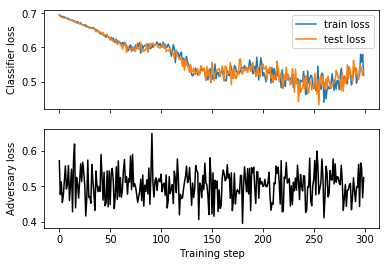

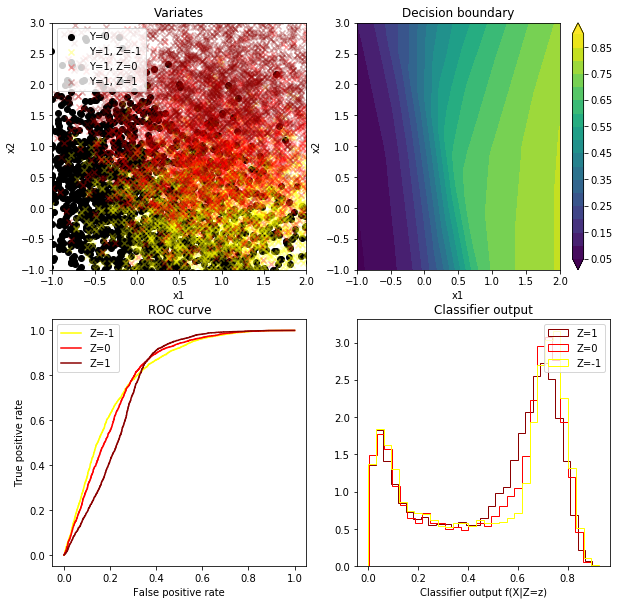

In [60]:
def adversarial_training(generating_function, N_train=200):
    
    # determine the size of hte classifier
    X, _, _ = generating_function(10)
    n_inputs = X.shape[1]
    
    # create the classifier and the adversary networks
    clf = Classifier(10, n_inputs=n_inputs)
    adv = Regressor(10)

    # training settings
    learning_rate = 0.001
    lam = 10.0 # lambda tradeoff parameter

    # choose the criterions
    clf_criterion = nn.BCELoss()
    adv_criterion = nn.MSELoss()

    # create optimisers (larger learning rate for the adversary )
    clf_optimiser = torch.optim.Adam(clf.parameters(), lr=learning_rate)
    adv_optimiser = torch.optim.Adam(adv.parameters(), lr=10*learning_rate)

    # keep track of the losses
    clf_losses = []
    adv_losses = []
    clf_losses_test = []
    adv_losses_test = []

    # training loop
    for _ in range(N_train):

        # create the data
        X, Y, Z = generating_function(512)
        X = torch.as_tensor(X, dtype=torch.float)
        Y = torch.as_tensor(Y.reshape(-1, 1), dtype=torch.float)
        Z = torch.as_tensor(Z.reshape(-1, 1), dtype=torch.float)

        ##############################
        # Update the adversary network
        ##############################
    
        # make the adversary loss
        clf_output = clf(X)
        adv_output = adv(clf_output)
        adv_loss = adv_criterion(adv_output, Z)
        adv_losses.append(adv_loss.data.numpy().item())
    
        # backprop: adapt the adversary to the classifier (only update the adversary weights)
        adv.zero_grad()
        adv_loss.backward()
        adv_optimiser.step()

        ##############################
        # Update the classifier network
        ##############################
    
        M = 1
        for i in range(M):
            # forward pass
            clf_output = clf(X)
            adv_output = adv(clf_output)
    
            # make the losses: both the classifier and the adversary loss
            # combined loss: note the minus sign!
            # (when updating the classifier, the goal is to confuse the adversary)
            clf_loss = clf_criterion(clf_output, Y)
            adv_loss = adv_criterion(adv_output, Z)
            comb_loss = clf_loss - lam * adv_loss
            
            # backprop the classifier: update only the classifier weights (keep adversary intact)
            clf.zero_grad()
            comb_loss.backward()
            clf_optimiser.step()
            
        clf_losses.append(clf_loss.data.numpy().item())
    
        #######################
        # store the test losses
        #######################
        X_test, Y_test, _ = generating_function(512, train=False)
        X_test = torch.as_tensor(X_test, dtype=torch.float)
        Y_test = torch.as_tensor(Y_test.reshape(-1, 1), dtype=torch.float)
        output_test = clf(X_test)
        loss_test = clf_criterion(output_test, Y_test)
        clf_losses_test.append(loss_test.data.numpy().item())
    
    print('Done with training')

    fig, ax = plt.subplots(2, sharex=True)
    ax[0].plot(range(len(clf_losses)), clf_losses, label='train loss')
    ax[0].plot(range(len(clf_losses_test)), clf_losses_test, label='test loss')
    ax[0].set_ylabel('Classifier loss')
    ax[0].legend(loc='best')
    ax[1].plot(range(len(adv_losses)), adv_losses, color='k')
    ax[1].set_ylabel('Adversary loss')
    ax[1].set_xlabel('Training step')
    plt.show()
    
    return clf


clf_toys_adv = adversarial_training(generate_toys, 300)
evaluate_classifier(clf_toys_adv, generate_toys)

# 2 Physics example

Here we look at a physically interesting situation: Search for a Standard Model Higgs boson produced in association with a vector boson decaying to a pair of bottom quarks (VH->bb). While there are several backgrounds in the real analysis we will focus on just one, Z+jets.

The goal of the classification task is to separate H->bb events from the Z+jets background without learning the mass of the di-b-jet system.

-----

Thanks to Philipp Windischhofer for producing and sharing these MadGraph samples!

## 2.1 Visualise the data

### Get the data

This will download ~12MB, will hopefully take no more than a minute.

In [61]:
import os
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

# download the data
if not 'MadGraph.pkl' in os.listdir():
    print('Downloading data:')
    !wget http://www-pnp.physics.ox.ac.uk/~zgubic/Hbb/MadGraph.pkl -O MadGraph.pkl
else:
    print('Data already downloaded')
    print(os.listdir())
    
# prepare the data
df = pd.read_pickle('MadGraph.pkl')
features = ['MET', 'pTB1', 'pTB2', 'dRBB', 'dEtaBB', 'dPhiMETdijet']
X = df[features]
Y = df[['Y']]
Z = df[['mBB']]

# preprocessing
X_pca = PCA(X.shape[1], svd_solver='auto', whiten=True)
Z_pca = PCA(Z.shape[1], svd_solver='auto', whiten=True)

X_pca.fit(X)
Z_pca.fit(Z)

# split
X_train, X_test, Y_train, Y_test, Z_train, Z_test = train_test_split(X, Y, Z)

def generate_hbb(n_samples, train=True):
    
    # test or train
    X_full = X_train if train else X_test
    Y_full = Y_train if train else Y_test
    Z_full = Z_train if train else Z_test

    # sample the events
    random_state = np.random.randint(0, 10000)
    X = X_full.sample(n_samples, random_state=random_state)
    Y = Y_full.sample(n_samples, random_state=random_state)
    Z = Z_full.sample(n_samples, random_state=random_state)
    
    # preprocess them
    return X_pca.transform(X), Y.values, Z_pca.transform(Z)

X, Y, Z = generate_hbb(5, train=True)


Data already downloaded
['.config', 'MadGraph.pkl', 'sample_data']


### Show the data

Here, let's take a look at a few kinematic variables for the signal and background samples.

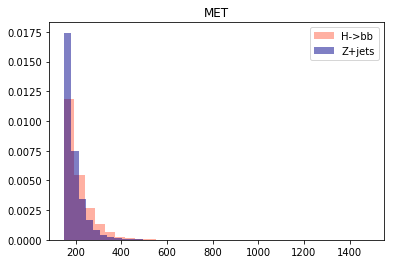

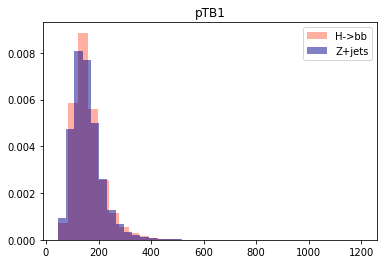

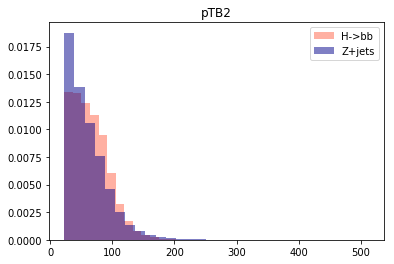

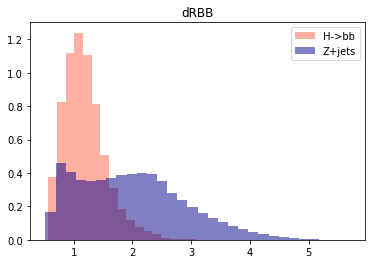

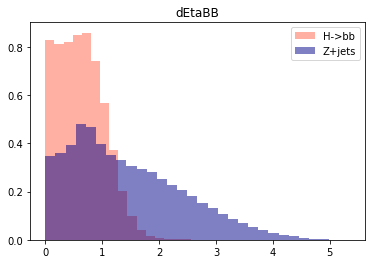

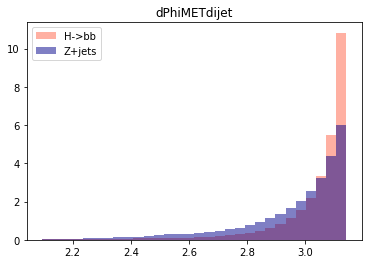

In [62]:
for feature in features:
    fig, ax = plt.subplots()
    _ = ax.hist(df.query('Y==1')[feature], bins=30, alpha=0.5, density=True, color='tomato', label='H->bb')
    _ = ax.hist(df.query('Y==0')[feature], bins=30, alpha=0.5, density=True, color='darkblue', label='Z+jets')
    ax.set_title(feature)
    ax.legend(loc='best')

## 2.2 Normal training

### Training

Done with training


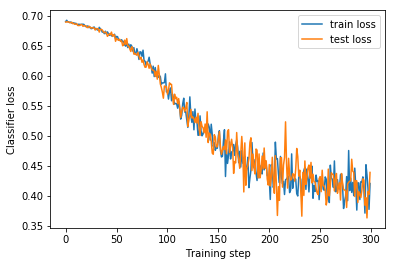

In [64]:
clf_hbb = normal_training(generate_hbb, 300)

### Evaluation

Lots of plotting code first, just look at the figures at the bottom.

It can be seen that the classifier learns the mass of the two b-quarks to be a powerful discriminating variable: it preferentially selects events around the Higgs boson mass.

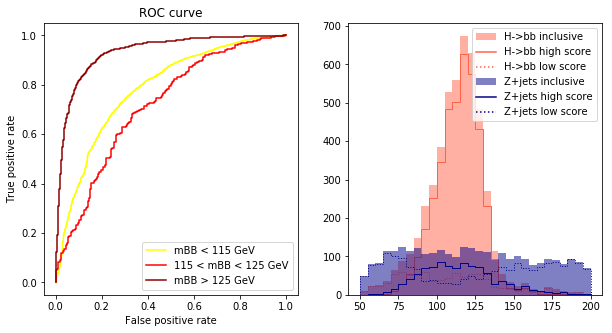

In [65]:
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

def show_roc_curves_hbb(ax, clf, generate):

    # generate test data
    n_samples = 10000
    X, Y, Z = generate(n_samples)
    
    # split events in the three mass ranges
    low_z = Z_pca.transform([[115]])
    high_z = Z_pca.transform([[125]])
    mask_1 = (Z < low_z).ravel()
    X_1 = X[mask_1]
    Y_1 = Y[mask_1]
    mask1 = (Z > high_z).ravel()
    X1 = X[mask1]
    Y1 = Y[mask1]
    mask0 = ((Z > low_z) & (Z < high_z)).ravel()
    X0 = X[mask0]
    Y0 = Y[mask0]

    # compute the roc curves
    Y0_pred = clf(torch.as_tensor(X0, dtype=torch.float))
    fpr0, tpr0, _ = roc_curve(Y0, Y0_pred.data)

    Y1_pred = clf(torch.as_tensor(X1, dtype=torch.float))
    fpr1, tpr1, _ = roc_curve(Y1, Y1_pred.data)

    Y_1_pred = clf(torch.as_tensor(X_1, dtype=torch.float))
    fpr_1, tpr_1, _ = roc_curve(Y_1, Y_1_pred.data)

    # draw the roc curves
    ax.plot(fpr_1, tpr_1, c='yellow', label='mBB < 115 GeV')
    ax.plot(fpr0, tpr0, c='red', label='115 < mBB < 125 GeV')
    ax.plot(fpr1, tpr1, c='darkred', label='mBB > 125 GeV')

    # cosmetics
    ax.legend(loc='best')
    ax.set_xlabel('False positive rate')
    ax.set_ylabel('True positive rate')
    ax.set_title('ROC curve')

def show_mass_distribution(ax, clf, generate):
    
    # generate test data
    n_samples = 10000
    X, Y, Z = generate(n_samples)
    
    # split events depending on the score they get
    Y_pred = clf(torch.as_tensor(X, dtype=torch.float)).detach().numpy()
    median = np.percentile(Y_pred, 50)

    # get the mass shape
    mass = Z_pca.inverse_transform(Z)
    
    # plot inclusive spectra, and spectra with high and low scores
    ax.hist(mass[Y==1], bins=30, range=(50, 200), alpha=0.5, label='H->bb', color='tomato')
    ax.hist(mass[(Y==1) & (Y_pred>median)], bins=30, range=(50, 200), histtype='step', color='tomato')
    ax.hist(mass[(Y==1) & (Y_pred<median)], bins=30, range=(50, 200), histtype='step', color='tomato', linestyle=':')
    
    ax.hist(mass[Y==0], bins=30, range=(50, 200), alpha=0.5, label='Z+jets', color='darkblue')
    ax.hist(mass[(Y==0) & (Y_pred>median)], bins=30, range=(50, 200), histtype='step', color='darkblue')
    ax.hist(mass[(Y==0) & (Y_pred<median)], bins=30, range=(50, 200), histtype='step', color='darkblue', linestyle=':')
    

    custom_lines = [Patch(facecolor='tomato', alpha=0.5),
                    Line2D([0], [0], color='tomato'),
                    Line2D([0], [0], color='tomato', linestyle=':'),
                    Patch(facecolor='darkblue', alpha=0.5),
                    Line2D([0], [0], color='darkblue'),
                    Line2D([0], [0], color='darkblue', linestyle=':'),
                   ]

    ax.legend(custom_lines, ['H->bb inclusive', 'H->bb high score', 'H->bb low score',
                             'Z+jets inclusive', 'Z+jets high score', 'Z+jets low score'])

def evaluate_hbb_classifier(clf, generate):

    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    show_roc_curves_hbb(ax[0], clf, generate_hbb)
    show_mass_distribution(ax[1], clf, generate_hbb)
    plt.show()

evaluate_hbb_classifier(clf_hbb, generate_hbb)

## 2.3 Adversarial training

### Easy Task

Now, a very short task for you! The key is to note that the adversarial training proceeds in exactly the same way as before, only with a different dataset. 

Task: Reuse the functions above to train your own adversarial classifier.



In [0]:
# <your code here>

# train the classifier here:

# evaluate the classifier here:



### Solutions

Done with training


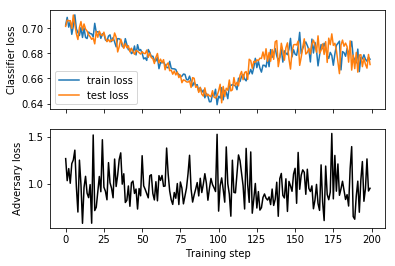

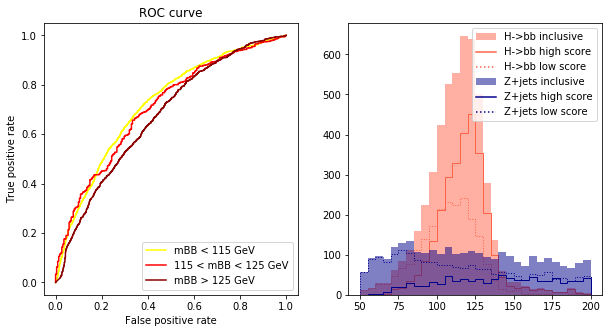

In [66]:
# <your code here>
#
# train the classifier here:
clf_hbb_adv = adversarial_training(generate_hbb, 200)
#
# evaluate the classifier here:
evaluate_hbb_classifier(clf_hbb_adv, generate_hbb)
#
#


### Harder task 1

Play around with the adversarial training parameters:

a) What happens if you increase the number of training steps? \\
b) How to get rid of the loss oscillations? Hint: is the task the adversary is trying to solve stationary? \\
c) Change classifier complexity: try a linear classifier, or increase the number of layers.



### Harder Task 2

If this is too easy, try using a different adversary:

  - Gaussian mixture model, as in the original paper [1] (Keras implementation at [2]), 
  
  or
 
  - Mutual Information Neural Estimator (MINE) [3] (Pytorch implementation at [4])

Gaussian mixture model essentially models the probability density distribution over the protected parameter Z, rather than a point estimate that we have used. The loss function is essentially a log likelihood.

MINE provides a differentiable estimate of the mutual information [5] between the output of the classifier and the protected parameter, allowing the classifier to change in a way which minimises it directly.


[1] https://arxiv.org/abs/1611.01046 \\
[2] https://github.com/glouppe/paper-learning-to-pivot/blob/master/code/Toy.ipynb \\
[3] https://arxiv.org/abs/1801.04062 \\
[4] https://github.com/MasanoriYamada/Mine_pytorch \\
[5] https://en.wikipedia.org/wiki/Mutual_information
